Stone Soup 03 - Particle Filter
====================

In [1]:
# Some general imports and set up
import matplotlib
%matplotlib inline

from datetime import timedelta
from datetime import datetime

import numpy as np

Simulate data
--------------
Like last time start we'll create a simple truth path, with position at 1 second interval. This will represent an object moving constantly in both $x$ and $y$.

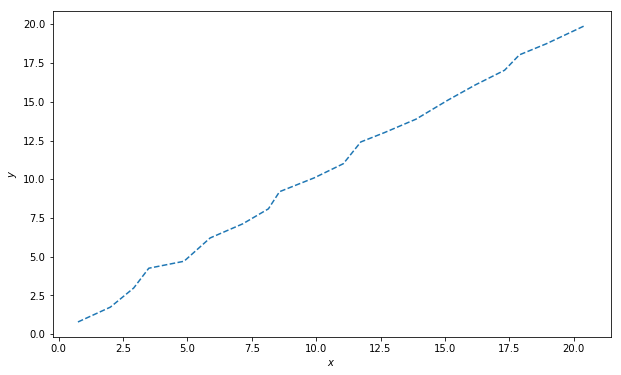

In [2]:
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState

# Figure to plot truth (and future data)
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

truth = GroundTruthPath()
start_time = datetime.now()
for n in range(1, 21):
    x = n
    y = n
    varxy = np.array([[0.05,0],[0,0.05]])
    xy = np.random.multivariate_normal(np.array([x,y]),varxy)
    truth.append(GroundTruthState(np.array([[xy[0]], [xy[1]]]), timestamp=start_time+timedelta(seconds=n)))

#Plot the result
ax.plot([state.state_vector[0, 0] for state in truth], 
        [state.state_vector[1, 0] for state in truth], 
        linestyle="--")

Again we'll take measurments as a range and bearing sensor based at location $(-20, -20)$.

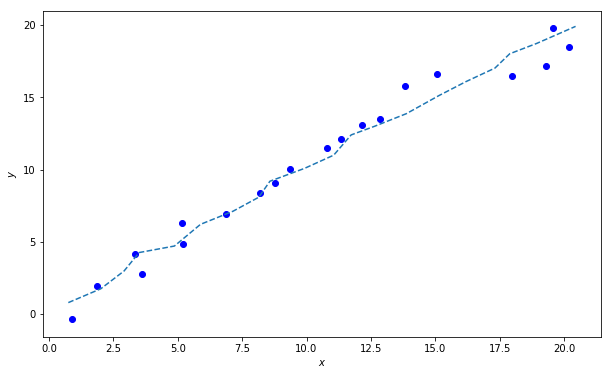

In [3]:
from scipy.stats import multivariate_normal

from stonesoup.types.detection import Detection
from stonesoup.types.angle import Bearing
from stonesoup.functions import cart2pol, pol2cart

measurements = []
sensor_x = 10
sensor_y = 0
for state in truth:
    x = state.state_vector[0, 0]
    y = state.state_vector[1, 0]
    delta_x = (x - sensor_x)
    delta_y = (y - sensor_y)
    rho, phi = multivariate_normal.rvs(
        cart2pol(delta_x, delta_y),
        np.diag([0.1, np.radians(0.1)]))
        
    measurements.append(Detection(
        np.array([[Bearing(phi)], [rho]]), timestamp=state.timestamp))
    
# Plot the result (back in cart.)
x, y = pol2cart(
    np.hstack(state.state_vector[1, 0] for state in measurements),
    np.hstack(state.state_vector[0, 0] for state in measurements))
ax.scatter(x + sensor_x,
           y + sensor_y,
           color='b')
fig

The sensor data can also be potted in polar.

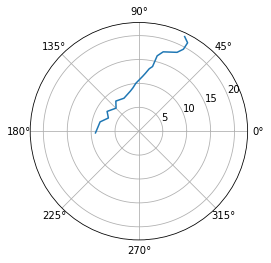

In [4]:
plt.polar([state.state_vector[0, 0] for state in measurements], 
        [state.state_vector[1, 0] for state in measurements])

Create Models and Particle Filter
------------------------------------------
Now we'll begin creating our Particle Filter.

The transition model and measurement models will be same as last time, but using a Particle Predictor and Updater.

In [5]:
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, ConstantVelocity
transition_model = CombinedLinearGaussianTransitionModel((ConstantVelocity(0.05), ConstantVelocity(0.05)))

In [6]:
from stonesoup.predictor.particle import ParticlePredictor
predictor = ParticlePredictor(transition_model)

In [7]:
from stonesoup.models.measurement.nonlinear import RangeBearingGaussianToCartesian
measurement_model = RangeBearingGaussianToCartesian(
    4, # Number of state dimensions (position and velocity in 2D)
    (0, 2), # Mapping measurement vector index to state index
    np.diag([np.radians(0.1), 0.1]),  # Covariance matrix for Gaussian PDF
    translation_offset=np.array([[sensor_x], [sensor_y]]) # Location of sensor in cartesian.
)

For a particle filter, we also need a resampler to refresh the particles to ensure they are more evenly weighted.

In [8]:
from stonesoup.resampler.particle import SystematicResampler
resampler = SystematicResampler()

With this, we can now build a Particle Updater object.

In [9]:
from stonesoup.updater.particle import ParticleUpdater
updater = ParticleUpdater(measurement_model, resampler)

Running the Particle Filter
------------------------------------
Now we have the components, we can run our simulated data through the Extended Kalman Filter.

To start, we'll need to create a prior estimaite of where we think our target will be, but in this case we'll need this to be a set of particles. For this, we sample from Guassian distribution (using same parameters we had in Kalman example).

In [10]:
from stonesoup.types.state import ParticleState
from stonesoup.types.particle import Particle
from stonesoup.types.numeric import Probability

number_particles = 200
samples = multivariate_normal.rvs(np.array([0, 1, 0, 1]),
                                  np.diag([1, 1, 1, 1]),
                                  size=number_particles)
particles = [
    Particle(sample.reshape(-1, 1), weight=Probability(1/number_particles))
    for sample in samples]
prior = ParticleState(
    particles,
    timestamp=start_time)

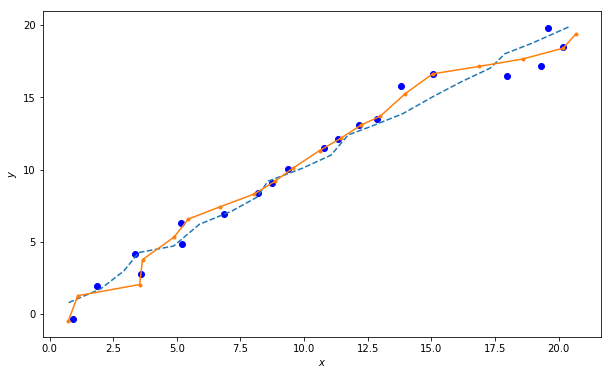

In [11]:
from stonesoup.types.hypothesis import SingleHypothesis
from stonesoup.types.track import Track

track = Track()
for measurement in measurements:
    prediction = predictor.predict(prior, timestamp=measurement.timestamp)
    hypothesis = SingleHypothesis(prediction, measurement) # Used to group a prediction and measurement together
    post = updater.update(hypothesis)
    track.append(post)
    prior = track[-1]

# Plot the resulting track
ax.plot([state.state_vector[0, 0] for state in track], 
        [state.state_vector[2, 0] for state in track],
        marker=".")
fig

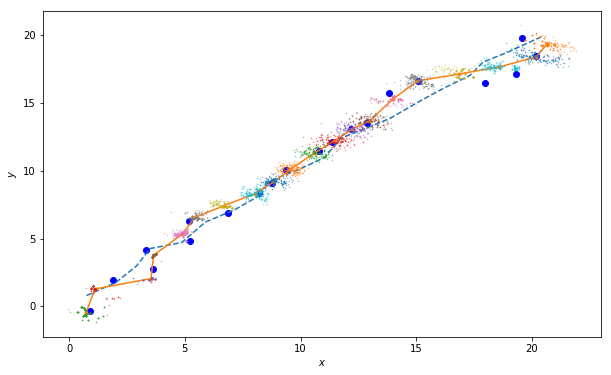

In [12]:
for state in track:
    data = np.array([particle.state_vector for particle in state.particles])
    ax.plot(data[:,0], data[:,2], linestyle='', marker=".", markersize=1, alpha=0.5)
fig